# Using Data Base in gstlearn

In this preamble, we load the **gstlearn** library.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

This is the (non-exhaustive) list of classes (of objects) in gstlearn:

* Db, DbGrid: numerical data base
* DirParam, VarioParam and Vario: experimental variograms
* Model: variogram model
* Neigh: neighborhood
* Anam: gaussian anamorphosis
* Polygon: 2-D polygonal shapes
* Rule: lithotype rule for thresholds used for truncated plurigaussian models

# Importing External File

## Loading CSV file

You should download the ASCII file called *Scotland_Temperatures.csv* (organized as a CSV file) and store it on your disk in temporary directory. In this example, the file (called *temp_csv*) is provided as a *CSV* format file. We load it into a data frame (names *datcsv*) using the relevant Python command.

In [3]:
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Temperatures.csv'
temp_csv, head = urllib.request.urlretrieve(url)

In [4]:
import pandas as pd
datcsv = pd.read_csv(temp_csv)
datcsv

,Longitude,Latitude,Elevation,January_temp
0,372.1,658.9,255,1.7
1,303.5,665.9,125,2
2,218.4,597.9,8,4.6
3,245.0,955.0,90,MISS
4,326.8,691.2,32,3.1
...,...,...,...,...
231,273.2,564.6,47,2.8
232,333.9,730.1,30,2.6
233,185.0,655.0,115,MISS
234,259.8,587.9,119,2.1


We can check the contents of the data frame (by simply typing its name) and see that it contains four columns (respectively called *Longitude*, *Latitude*, *Elevation*, *January_temp*) and 236 rows (header line excluded).

Note that the last column contains several values called *MISS*: this corresponds to the absence of information.

## Creating Db File from CSV

We now want to load this information in order to obtain a data base of the gstlearn package (or *Db*) that will be called *dat*. This operation can be performed directly by reading the CSV file again and load it directly into a Db.

Note that we introduce a *CSVformat* description where we can specifiy the specificities of the file to be read, in particular we can tell how to spell the conventional value used for coding missing information.

In [5]:
csv = gl.CSVformat.create(flagHeader=True, naString = "MISS")
dat = gl.Db.createFromCSV(temp_csv, csv=csv)
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 0
Number of Columns            = 5
Maximum Number of UIDs       = 5
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = NA
Column = 2 - Name = Latitude - Locator = NA
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = NA

## Creating Db File from a Pandas frame

The user can also directly create a Db from the previously imported Pandas frame. Missing values (*MISS*) must be replaced by *np.nan* beforehand. Then, the corresponding column must be converted into a numerical python type.

In [6]:
# Replace missing values and convert to numeric from the Pandas frame
datcsv["January_temp"].replace("MISS", np.nan, inplace=True)
datcsv = datcsv.astype("float64")
# Create an empty Db
dat = gl.Db()
# And import all columns in one instruction using [] operator
dat[list(datcsv.columns)] = datcsv
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 0
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 236

Variables
---------
Column = 0 - Name = Longitude - Locator = NA
Column = 1 - Name = Latitude - Locator = NA
Column = 2 - Name = Elevation - Locator = NA
Column = 3 - Name = January_temp - Locator = NA

## Importing Db File from a "Neutral File"

A last solution is to import it directly from the set of demonstration files (provided together with the package and called *temp_nf*) and stored in a specific format (Neutral file). 

These *NF* (or neutral file) are currently used for serialization of the gstlearn objects. They will probably be replaced in the future by a facility backuping the whole workspace in one step.

Note that the contents of the Db is slightly different from the result obtained when reading from CSV. Essentially, some variables have a *Locator* field defined, some do not. This concept will be described later in this chapter and the difference can be ignored.

In [7]:
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Temperatures.NF'
temp_nf, head = urllib.request.urlretrieve(url)
dat = gl.Db.createFromNF(temp_nf)
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Maximum Number of UIDs       = 5
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = z1

# Discovering Db

## The Db class

Typing the name of the object automatically launches the **display**. It is equivalent to simply typing the name of the object (at the end of a cell in a jupyter notebook).


In [8]:
dat.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Maximum Number of UIDs       = 5
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = z1
 

There, we can check that the 4 initial fields have been considered, in addition to a firs one, automatically called *rank*, for a total of 5 columns (the information regarding *UID* will not be addressed in this chapter).

We can check that each field is assigned to a numbered *Column*. Finally the total number of samples is 236 as expected.

In addition, some interesting information tells you that this data base corresponds to a 2-D dimension one: this will be described later together with the use of the *Locator* information.


To get more information on the contents of the Db, it is possible to use the *DbStringFormat* option and to use use through the *display* method. There are several ways to specify the type of information that is searched for (see the documentation of this class for details): typically here we ask for statistics but restrict them to a list of variables 

In [9]:
dbfmt = gl.DbStringFormat.createFromFlags(flag_stats=True, names=["Elevation", "January_temp"])
dat.display(dbfmt)


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Maximum Number of UIDs       = 5
Total number of samples      = 236

Data Base Statistics
--------------------
4 - Name Elevation - Locator NA
 Nb of data          =        236
 Nb of active values =        236
 Minimum value       =      2.000
 Maximum value       =    800.000
 Mean value          =    146.441
 Standard Deviation  =    165.138
 Variance            =  27270.713
5 - Name January_temp - Locator z1
 Nb of data          =        236
 Nb of active values =        151
 Minimum value       =      0.600
 Maximum value       =      5.200
 Mean value          =      2.815
 Standard Deviation  =      1.010
 Variance            =      1.020

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = 

We can also consider the data base as a data frame and use the *[  ]* assessors. The following usage show the whole contents of the data base.

In [10]:
dat[:]

array([[  1. , 372.1, 658.9, 255. ,   1.7],
       [  2. , 303.5, 665.9, 125. ,   2. ],
       [  3. , 218.4, 597.9,   8. ,   4.6],
       ...,
       [234. , 185. , 655. , 115. ,   nan],
       [235. , 259.8, 587.9, 119. ,   2.1],
       [236. , 260.8, 668.6, 107. ,   2.6]])

We can access to one or several variables. Note that the contents of the Column corresponding to the target variable (i.e. *January_temp*) is produced as a 1D **numpy array** (printed along a line). 

Also note the presence of samples with *nan* corresponding to those where the target variable is not informed (*'MISS'* in the original dataset).

In [11]:
dat["January_temp"]

array([1.7, 2. , 4.6, nan, 3.1, 3.5, 3.4, 3. , 4.9, 2.9, nan, 1.3, nan,
       4. , 1.7, nan, 1.9, 3.3, 2.3, nan, 2.3, 2.6, nan, 2.7, 2.9, nan,
       1. , 1.2, nan, 3.1, nan, 3.7, 2.1, 2.5, 2.9, nan, nan, nan, 3.1,
       2.1, nan, 2.7, 3. , nan, nan, 1.8, nan, nan, 2.2, 2.9, 3.3, nan,
       5. , 1.6, nan, 2.1, 3.2, 4.2, 1.1, nan, 2.7, 0.6, 3.2, nan, 2.5,
       2. , 2.8, nan, 3.2, 3.2, 4.5, 3.3, 4.1, 2.2, 1.7, 4.3, 5.2, nan,
       1.6, 3.9, 3.1, nan, 3.5, 4.7, 3.6, nan, 1.8, 1.7, nan, nan, nan,
       nan, nan, nan, nan, 1.7, nan, 3. , 4.6, 3.9, 3.2, 1.3, nan, nan,
       nan, 4.7, nan, 2.6, 2. , 4.7, 1.2, 2.9, 0.9, 3. , nan, 3.6, 0.7,
       3.3, nan, nan, nan, 2.7, nan, 2.7, 2.4, nan, nan, 2. , 2.6, nan,
       4.3, nan, nan, nan, nan, 3.1, 3.4, 3.1, 2. , 1.3, 1.9, nan, 3.3,
       2.7, 4.4, nan, 3. , 0.9, 0.7, nan, 3.6, nan, 3.5, nan, 2.4, 1. ,
       nan, 3.6, nan, nan, nan, nan, 3. , nan, 3.5, 4. , 3. , 3.6, nan,
       3.2, 1.7, 2.7, 1.9, nan, nan, 4.4, 1.9, 3.3, nan, nan, 3.

But it can be more restrictive as in the following paragraph, where we only consider the samples 10 to 15, and only consider the variables *Latitude* and *Elevation*. Remind that indices start from 0 to N-1 in Python.

In [12]:
dat[10:15, ["Latitude", "Elevation"]]

array([[865. ,  37. ],
       [602.6, 242. ],
       [835. , 295. ],
       [933.2,  15. ],
       [648.8, 183. ]])

We can also replace the variable *Name* by their *Column* index. Although this is not recommanded as the Column index may vary over time.

In [13]:
dat[10:15, 2:4]

array([[865. ,  37. ],
       [602.6, 242. ],
       [835. , 295. ],
       [933.2,  15. ],
       [648.8, 183. ]])

Please also note the feature that a variable whose name does not exist (*newvar*) in the data base, is created on the fly. Also note that variables may be specified with names referred to using traditional regexp expressions (i.e. the symbol '*' replaces any list of characters):

In [14]:
dat["newvar"] = 12.3 * dat["Elevation"] - 2.1 * dat["*temp"]
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 6
Maximum Number of UIDs       = 6
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = z1
Column = 5 - Name = newvar - Locator = NA

The user also can remove a variable from the Data base by doing the following:

In [46]:
dat.deleteColumn("newvar")
dat.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Maximum Number of UIDs       = 6
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = z1
 

## Locators

The locators are used to specify the **role** assigned to a Column for the rest of the study (unless changed further). The locator is characterized by its name (*Z* for a variable and *X* for a coordinate) within the Enumeration *ELoc* and its rank.

In [15]:
dat.setLocators(["Longitude","Latitude"], gl.ELoc.X)
dat.setLocator("*temp", gl.ELoc.Z, cleanSameLocator=True)
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 6
Maximum Number of UIDs       = 6
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = z1
Column = 5 - Name = newvar - Locator = NA

As can be seen in the printout, variables *Latitude* and *Longitude* have been designated as coordinates (pay attention to the order) and *January_temp* is the (unique) variable. Therefore any subsequent step will be performed as a monovariate 2-D process.

The locator is translated into a *letter*,*number* pair for better legibility: e.g. *x1* for the first coordinate.


## Plotting a Db

Plot the contents of a Db using functions of the **gstlearn.plot** sub-package (which relies on **matplotlib**). The proportional option (**name_size**) is used to represent the **january_temp** variable.

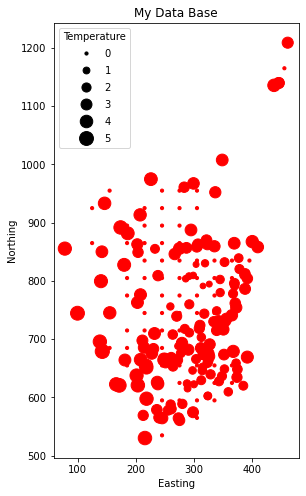

In [16]:
fig, ax = gp.initGeographic()
ax.symbol(dat, name_size="*temp", flagLegend=True, legendName="Temperature")
ax.decoration(title="My Data Base", xlabel="Easting", ylabel="Northing")
plt.show()

A more elaborated graphic representation displays the samples with a symbol proportional to the Elevation (**name_size**) and a color representing the Temperature (**name_color**).

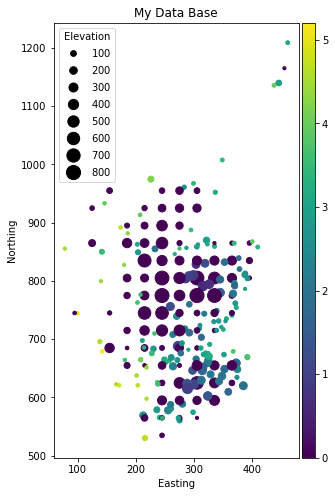

In [36]:
fig, ax = gp.initGeographic()
ax.symbol(dat, name_size="Elevation", name_color="*temp", flagLegend=True, legendName="Elevation")
ax.decoration(title="My Data Base", xlabel="Easting", ylabel="Northing")
plt.show()

Of course, you can use your own graphical routines (for example, a direct call to **matplotlib**) by simply accessing to the *gstlearn* Database values (using '[ ]' accessor):

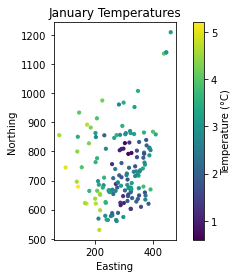

In [32]:
plt.scatter(dat["x1"], dat["x2"], s=10, c=dat["*temp"]) # Locator or variable name is OK
plt.title("January Temperatures")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.colorbar(label="Temperature (°C)")
plt.gca().set_aspect('equal') # Respect aspect ratio
plt.show()

# Some statistics

We use a specific object of type *DbStringFormat* in order to configure the *display* method for the Data base object. A lot of different flags are available. Here is an example using **flag_stats** which permits showing basics monovariate statistics for all the Data base variables.

In [47]:
dbfmt = gl.DbStringFormat.createFromFlags(flag_stats=True)
dat.display(dbfmt)


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Maximum Number of UIDs       = 6
Total number of samples      = 236

Data Base Statistics
--------------------
1 - Name rank - Locator NA
 Nb of data          =        236
 Nb of active values =        236
 Minimum value       =      1.000
 Maximum value       =    236.000
 Mean value          =    118.500
 Standard Deviation  =     68.127
 Variance            =   4641.250
2 - Name Longitude - Locator x1
 Nb of data          =        236
 Nb of active values =        236
 Minimum value       =     78.200
 Maximum value       =    460.700
 Mean value          =    282.487
 Standard Deviation  =     71.704
 Variance            =   5141.440
3 - Name Latitude - Locator x2
 Nb of data          =        236
 Nb of active values =        236
 Minimum value       =    530.400
 Maximum value       =   1208.900
 Mean value

# Grid Data Base

On the same area, a terrain model is available (as a demonstration file available in the package distribution). We first download it and create the corresponding data base defined on a grid support (*DbGrid*).

In [33]:
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Elevations.NF'
elev_nf, head = urllib.request.urlretrieve(url)
grid = gl.DbGrid.createFromNF(elev_nf)
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 11097
Number of active samples     = 3092

Grid characteristics:
---------------------
Origin :     65.000   535.000
Mesh   :      4.938     4.963
Number :         81       137

Variables
---------
Column = 0 - Name = Longitude - Locator = x1
Column = 1 - Name = Latitude - Locator = x2
Column = 2 - Name = Elevation - Locator = f1
Column = 3 - Name = inshore - Locator = sel

We can check that the grid is constituted of 81 columns and 137 rows, or 11097 grid cells. We can also notice that some locators are already defined (these information are stored in the Neutral File).


## Selection

We can check the presence of a variable (called *inshore*) which is assigned to the *sel* locator: this corresponds to a *Selection* which acts as a binary filter: some grid cells are active and others are masked off. The count of active samples is given in the previous printout (3092). This selection remains active until the locator 'sel' is replaced or deleted (there may not be more than one selection defined at a time per data base). This is what can be seen in the following display where the *Elevation* is automatically represented **only** within the *inshore* selection.

Note that any variable (having values equal to 0/1 or True/False) can be considered as a Selection: it must simply be assigned to the *sel* locator using the *setLocator* method described earlier.

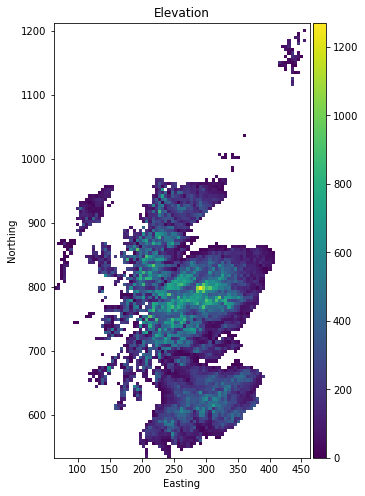

In [50]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Elevation", flagLegend=True)
ax.decoration(title="Elevation", xlabel="Easting", ylabel="Northing")
plt.show()

On this final plot, we combine grid and point representations.

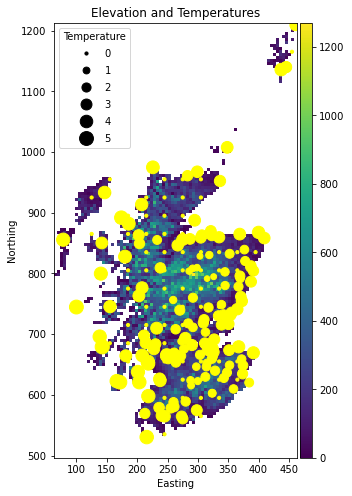

In [51]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Elevation", flagLegend=True)
ax.symbol(dat, name_size="*temp", flagLegend=True, legendName="Temperature", c="yellow")
ax.decoration(title="Elevation and Temperatures", xlabel="Easting", ylabel="Northing")
plt.show()